# Import

In [36]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader, Dataset
from torch.utils.data import random_split
from torchvision.utils import make_grid
from skimage import io
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import Tuple, NoReturn
import seaborn as sns
import time
import pandas as pd
from PIL import Image

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloader

In [4]:
class PetsDataset(Dataset):
    #CLASS-ID 1-37 different breeds 
    def __init__(self,image_dir: str,annotation_dir: str, train: bool,test:bool,val:bool,transform):
        super().__init__()

        if train:
            self.data = pd.read_csv(os.path.join(annotation_dir,"trainval.txt"),delimiter=" ",header=None)
        elif val:
            self.data = pd.read_csv(os.path.join(
                annotation_dir, "test.txt"), delimiter=" ")
        else:
            self.data = pd.read_csv(os.path.join(
                annotation_dir, "test.txt"), delimiter=" ")
        
        self.image_dir = image_dir
        self.transform = transform
        self.train = train


        
    def __len__(self):

        return self.data.shape[0]
    
    def __getitem__(self,idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
 
        image_pth = os.path.join(self.image_dir,self.data.iloc[idx,0]+ ".jpg")
        
        image = Image.open(image_pth).convert("RGB")
       
        label = int(self.data.iloc[idx, 1]) - 1
        
        if self.transform:

            image = self.transform(image)

        
        return image,label

In [5]:
#Transformations

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=5),
    transforms.Resize((256, 256)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
#Initialise Dataset
pets_dataset_train = PetsDataset(image_dir="data/images/",annotation_dir="data/annotations/",train=True,val=False,test=False,transform=transform)
pets_dataset_val= PetsDataset(image_dir="data/images/", annotation_dir="data/annotations/",
                                 train=False, val=True, test=False, transform=transform_test)

pets_dataset_test = PetsDataset(image_dir="data/images/", annotation_dir="data/annotations/",
                               train=False, val=False, test=True, transform=transform_test)


In [6]:
BATCH_SIZE = 8
NUM_WORKERS = 4
SHUFFLE = True

#Dataloader
train_loader = DataLoader(pets_dataset_train,batch_size=BATCH_SIZE,shuffle=SHUFFLE)
test_loader = DataLoader(pets_dataset_test,batch_size=BATCH_SIZE,shuffle=SHUFFLE)
val_loader = DataLoader(pets_dataset_val,batch_size=BATCH_SIZE,shuffle=SHUFFLE)

## Visualizing Data

In [7]:
label_dict = {1: 'abyssinian',
              2: 'american_bulldog',
              3: 'american_pit_bull_terrier',
              4: 'basset_hound',
              5: 'beagle',
              6: 'bengal',
              7: 'birman',
              8: 'bombay',
              9: 'boxer',
              10: 'british_shorthair',
              11: 'chihuahua',
              12: 'egyptian_mau',
              13: 'english_cocker_spaniel',
              14: 'english_setter',
              15: 'german_shorthaired',
              16: 'great_pyrenees',
              17: 'havanese',
              18: 'japanese_chin',
              19: 'keeshond',
              20: 'leonberger',
              21: 'maine_coon',
              22: 'miniature_pinscher',
              23: 'newfoundland',
              24: 'persian',
              25: 'pomeranian',
              26: 'pug',
              27: 'ragdoll',
              28: 'russian_blue',
              29: 'saint_bernard',
              30: 'samoyed',
              31: 'scottish_terrier',
              32: 'shiba_inu',
              33: 'siamese',
              34: 'sphynx',
              35: 'staffordshire_bull',
              36: 'wheaten_terrier',
              37: 'yorkshire_terrier'
              }


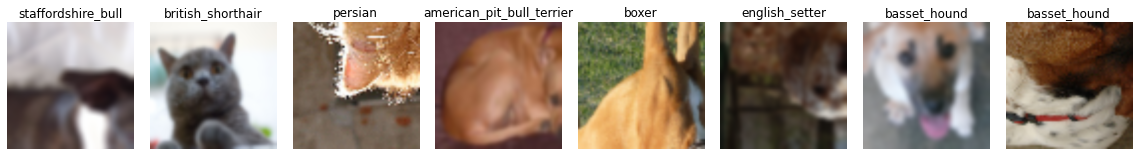

In [8]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)

    plt.figure(figsize=(8*2, 4*2))
    for i in range(8):
        plt.subplot(4, 8, i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()


# Get a batch of training data and displaying it
image,label = next(iter(train_loader))



titles = [label_dict[x.item()+1] for x in label]

show_grid(image, titles=titles)


# Main Code

In [84]:
def save_model(model, optimizer, epoch, stats,name):
    """ Saving model checkpoint """

    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}_{name}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """

    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]

    return model, optimizer, epoch, stats


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]]
                       )  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return


def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    ax = plt.subplot()

    # annot=True to annotate cells, ftm='g' to disable scientific notation
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    x_axis = [v for v in label_dict.values()]
    y_axis = [v for v in label_dict.values()]
    ax.set_xticks([k for k in label_dict.keys()])
    ax.set_yticks([k for k in label_dict.keys()])
    ax.set_xticklabels(x_axis, rotation=90)
    ax.set_yticklabels(y_axis, rotation=0)


In [68]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device).long()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    count = 0
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device).long()
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
        count+=1
          
    # Total correct predictions and loss
    accuracy = (correct / len(eval_loader.dataset)) * 100
    
    loss = np.mean(loss_list)
    
    return accuracy, loss


def test_model(model):

    correct = 0
    total = 0
    labels_out = []
    pred_labels = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        pred_labels.append(preds.detach().cpu().numpy())
        labels_out.append(labels.detach().cpu().numpy())
        correct += len(torch.where(preds == labels)[0])
        total += len(labels)

    # Total correct predictions and loss
    accuracy = correct / total * 100

    return accuracy,labels_out, pred_labels


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs,name):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
            
        if scheduler is not None:

            scheduler.step()
        
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy} %")
            print("\n")
    
    print(f"Training completed")
    stats = {'train_loss': train_loss,
             'val_loss': val_loss,
             'loss_iters': loss_iters,
             'val_accuracy': valid_acc}

    save_model(model, optimizer, epoch, stats,name)
    return train_loss, val_loss, loss_iters, valid_acc

# Loading Model 

In [45]:
set_random_seed()

In [11]:
#Loading Pretrained Network
model = torchvision.models.resnet50(pretrained=True)

#Modifying the last layer of the Network
in_features_fc = model.fc.in_features
model.fc = nn.Linear(in_features_fc,37)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training and Evaluation

In [12]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


#Learning rate scheduling
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [13]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
    model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
    train_loader=train_loader, valid_loader=val_loader, num_epochs=20,name="resnet50_new"
)

del model

100%|██████████| 460/460 [00:55<00:00,  8.24it/s]


Epoch 1/20
    Train loss: 2.91768
    Valid loss: 3.69026
    Accuracy: 1.88113413304253 %




100%|██████████| 460/460 [00:55<00:00,  8.36it/s]


Epoch 6/20
    Train loss: 1.7042
    Valid loss: 2.00594
    Accuracy: 47.00109051254089 %




100%|██████████| 460/460 [00:57<00:00,  7.97it/s]


Epoch 11/20
    Train loss: 1.09684
    Valid loss: 1.82302
    Accuracy: 53.81679389312977 %




100%|██████████| 460/460 [00:58<00:00,  7.85it/s]


Epoch 16/20
    Train loss: 0.97797
    Valid loss: 1.35672
    Accuracy: 62.486368593238815 %




100%|██████████| 460/460 [00:57<00:00,  8.00it/s]


Epoch 20/20
    Train loss: 0.9566
    Valid loss: 1.42476
    Accuracy: 62.02290076335878 %


Training completed


## Training DenseNet

In [12]:
#Loading Pretrained Network
model_dense = torchvision.models.densenet121(pretrained=True)

#Modifying the last layer of the Network
in_features_fc = model_dense.classifier.in_features
model_dense.classifier = nn.Linear(in_features_fc, 37)

model_dense.to(device)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
criterion_dense = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_dense = torch.optim.Adam(model_dense.parameters(), lr=1e-4)


#Learning rate scheduling
scheduler_dense = torch.optim.lr_scheduler.StepLR(
    optimizer_dense, step_size=10, gamma=0.1)


In [14]:

train_loss_dense, val_loss_dense, loss_iters_dense, valid_acc_dense = train_model(
    model=model_dense, optimizer=optimizer_dense, scheduler=scheduler_dense, criterion=criterion_dense,
    train_loader=train_loader, valid_loader=val_loader, num_epochs=20,name="densenet121"
)

del model_dense

100%|██████████| 460/460 [00:56<00:00,  8.20it/s]


Epoch 1/20
    Train loss: 3.11239
    Valid loss: 3.67048
    Accuracy: 1.772082878953108 %




100%|██████████| 460/460 [00:56<00:00,  8.13it/s]


Epoch 6/20
    Train loss: 1.48871
    Valid loss: 1.41324
    Accuracy: 59.787350054525625 %




100%|██████████| 460/460 [00:56<00:00,  8.17it/s]


Epoch 11/20
    Train loss: 1.0792
    Valid loss: 1.16347
    Accuracy: 66.63031624863686 %




100%|██████████| 460/460 [00:59<00:00,  7.76it/s]


Epoch 16/20
    Train loss: 0.89038
    Valid loss: 0.92137
    Accuracy: 72.95528898582334 %




100%|██████████| 460/460 [00:54<00:00,  8.41it/s]


Epoch 20/20
    Train loss: 0.81725
    Valid loss: 0.96698
    Accuracy: 72.41003271537623 %


Training completed


# Plots

## Load Data

In [16]:
# Model dense

savepath = os.path.join(os.getcwd(
), "models/", "checkpoint_epoch_19_densenet121.pth")

model_dense = torchvision.models.densenet121(pretrained=True)

in_features_fc = model_dense.classifier.in_features
model_dense.classifier = nn.Linear(in_features_fc, 37)
optimizer_dense = torch.optim.Adam(model_dense.parameters(), lr=3e-6)

model_dense.to(device)
model_dense_1, optimizer_dense1, epoch_dense1, stats_dense1 = load_model(
    model=model_dense, optimizer=optimizer_dense, savepath=savepath)


In [18]:
# Model ResNet

savepath = os.path.join(os.getcwd(
), "models/", "checkpoint_epoch_19_resnet50_new.pth")

model = torchvision.models.resnet50(pretrained=True)

in_features_fc = model.fc.in_features
model.fc = nn.Linear(in_features_fc, 37)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

model.to(device)

model_resnet1, optimizer_resnet1, epoch_resnet1, stats_resnet1 = load_model(
    model=model, optimizer=optimizer, savepath=savepath)


In [19]:
train_losses_resnet = np.array(stats_resnet1['train_loss'], dtype=np.float)
train_losses_dense = np.array(stats_dense1['train_loss'], dtype=np.float)

val_losses_resnet = np.array(stats_resnet1['val_loss'], dtype=np.float)
val_losses_dense = np.array(stats_dense1['val_loss'], dtype=np.float)



/home/dhagash/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/home/dhagash/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/home/dhagash/anaconda3/envs/

## Visualizing Results

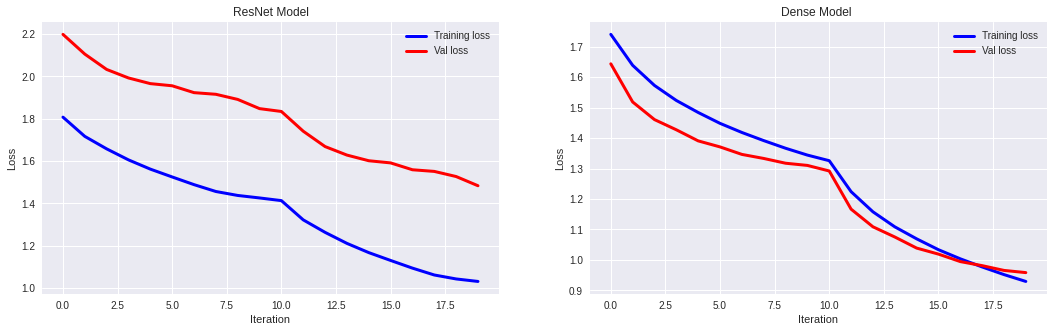

In [20]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 5)


ax[0].plot(smooth(train_losses_resnet, 20), c="blue",
           label="Training loss", linewidth=3)
ax[0].plot(smooth(val_losses_resnet, 20),
           c="red", label="Val loss", linewidth=3)
ax[0].set_title("ResNet Model")
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")


ax[1].plot(smooth(train_losses_dense, 20), c="blue",
           label="Training loss", linewidth=3)
ax[1].plot(smooth(val_losses_dense, 20),
           c="red", label="Val loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_title("Dense Model ")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")

plt.show()

- With more training I guess the accuracies can be bit higher but with due to limited resources we ran till 20 epochs only
- DenseNet is showing better results its expected as there are more dense connections from initially CNNs as well
- We beleive DenseNet with proper augmentation can achieve higher accuracies 

## Confusion Matrix

### ResNet

In [101]:
acc_resnet, labels_resnet,pred_resnet = test_model(model_resnet1)

In [103]:
labels_resnet = np.concatenate(labels_resnet,axis=0)
pred_resnet = np.concatenate(pred_resnet,axis=0)

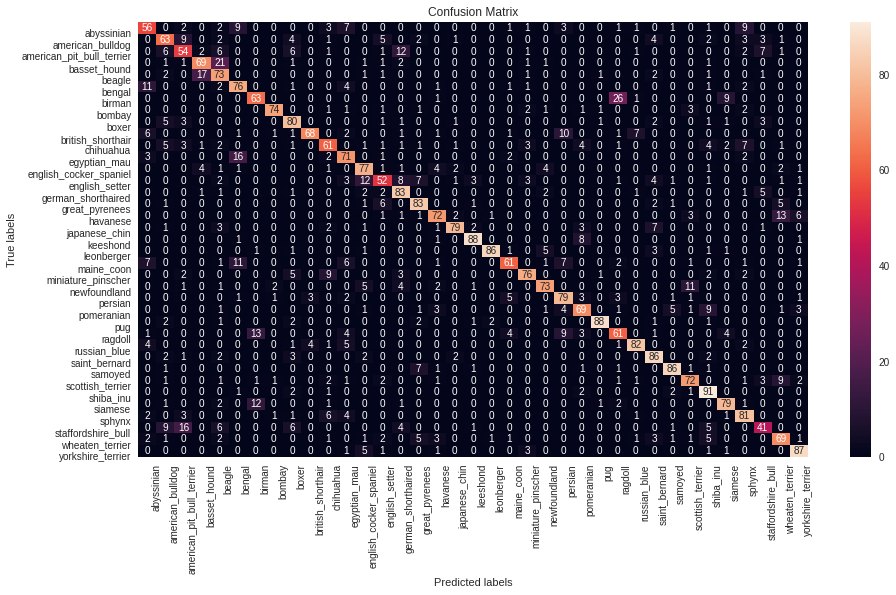

In [104]:
cm_resnet = confusion_matrix(labels_resnet,pred_resnet)

plot_confusion_matrix(cm_resnet)
plt.gcf().set_size_inches(15, 8)

plt.show()

**Most Confused Category Counted above 20 misclassification**
- Basset Hound, Beagle
- Pug Birman

**Accuracy is 73.85**

### DenseNet

In [86]:
acc_dense, labels_dense,pred_dense = test_model(model_dense)

In [90]:
labels_dense = np.concatenate(labels_dense,axis=0)
pred_dense = np.concatenate(pred_dense,axis=0)

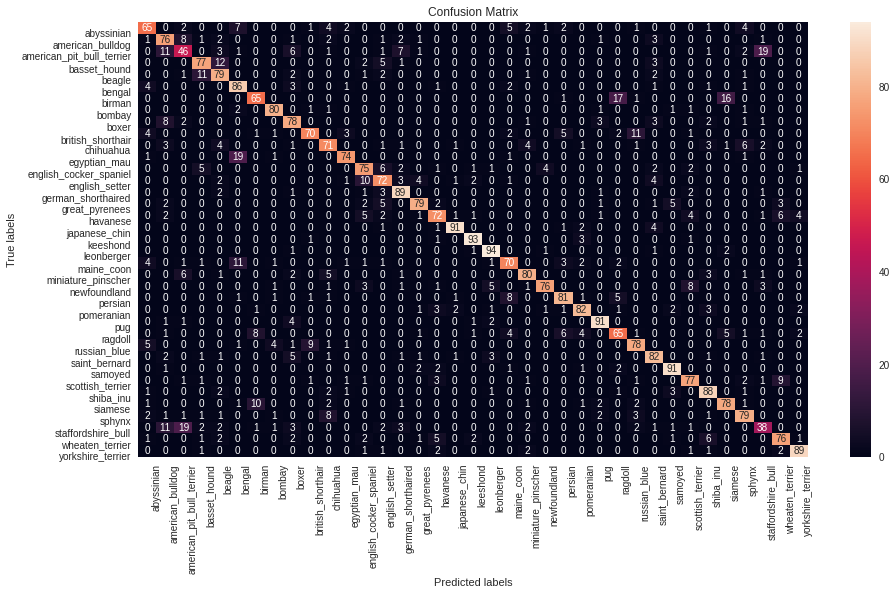

In [91]:
cm_dense = confusion_matrix(labels_dense, pred_dense)

plot_confusion_matrix(cm_dense)
plt.gcf().set_size_inches(15, 8)

plt.show()


**Most Confused Category Counted above 20 misclassification**

- Pug Birman

**Accuracy is 77.78**





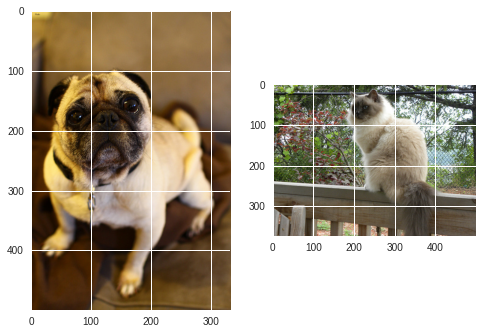

In [100]:
pug = plt.imread("data/images/pug_100.jpg")
birman = plt.imread("data/images/Birman_146.jpg")


f,ax = plt.subplots(1,2)

ax[0].imshow(pug)
ax[1].imshow(birman)

plt.show()

**General Observation**

- Pug and Birman are the most common to be missclassified in both the networks
- As you can see network learn pixel values and both of them if you say they have white body black face similarity in features and hence misclassification

# Conclusion

**Remarks**

- We tried our best but here were not able to achieve decent results dont know any particular reason
- Here again augmentation helped but LR schedular and deciding LR were the key to achieve better accuracies

**Conclusion**

- We can enlarge the dataset in relative less expensive way by data augmentation which boosts accuracy by large amount
- LR Scheduling and LR are key in fine tuning networks